# Debugging bbox coordinates starting from a single image

In [15]:
import httpx
import time
import torchvision.transforms as tf
import torch
from PIL import Image
import onnx
import numpy as np
import onnxruntime as ort
import os
import sys
from PIL import ImageDraw

In [4]:
import numpy as np
import cv2
import base64
import torch
import torchvision.transforms as tf
import torchvision
import io
from PIL import Image

img_size = 1280
min_conf_thresh = 0.00001


def preprocess(image):
    """Converts input images to float tensors.
    Args:
        data (List): Input data from the request in the form of a list of image tensors.
    Returns:
        Tensor: single Tensor of shape [BATCH_SIZE=1, 3, IMG_SIZE, IMG_SIZE]
    """
    # force convert to tensor
    # and resize to [img_size, img_size]
    image = np.asarray(image)
    original_image_shape = image.shape
    image, ratio, dw_dh = letterbox(image, new_shape=img_size,
                stride=64, auto=True)  # JIT requires auto=False\
    letterbox_shape = image.shape
    image = image.transpose((2, 0, 1))  # HWC to CHW; PIL Image is RGB already
    image = np.ascontiguousarray(image)
    image = torch.from_numpy(image)
    # image = image.to(self.device)
    image = image.float()
    image /= 255
    image = torch.unsqueeze(image, 0)
    # has shape BATCH_SIZE=1 x 3 x IMG_SIZE x IMG_SIZE
    return image, original_image_shape, letterbox_shape

def preprocess_onnx(image):
    """Converts input images to float tensors.
    Args:
        data (List): Input data from the request in the form of a list of image tensors.
    Returns:
        Tensor: single Tensor of shape [BATCH_SIZE=1, 3, IMG_SIZE, IMG_SIZE]
    """
    # force convert to tensor
    # and resize to [img_size, img_size]
    image = np.asarray(image)
    original_image_shape = image.shape
    image, ratio, dw_dh = letterbox(image, new_shape=(960,1280),
                stride=64, scaleup=False, auto=False)  # JIT requires auto=False\
    letterbox_shape = image.shape
    image = image.transpose((2, 0, 1))  # HWC to CHW; PIL Image is RGB already
    image = np.ascontiguousarray(image)
    image = torch.from_numpy(image)
    # image = image.to(self.device)
    image = image.float()
    image /= 255
    image = torch.unsqueeze(image, 0)
    # has shape BATCH_SIZE=1 x 3 x IMG_SIZE x IMG_SIZE
    return image, original_image_shape, letterbox_shape

def postprocess(inference_output, original_image_shape, letterbox_shape):
    # perform NMS (nonmax suppression) on model outputs
    pred = non_max_suppression(inference_output, conf_thres=min_conf_thresh, iou_thres=.45)

    # initialize empty list of detections for each image
    detections = [[] for _ in range(len(pred))]

    for i, image_detections in enumerate(pred):  # axis 0: for each image
        for det in image_detections:  # axis 1: for each detection
            det[:4] = scale_boxes(letterbox_shape, det[:4], original_image_shape)
            # x1,y1,x2,y2 in normalized image coordinates (i.e. 0.0-1.0)
            xyxy = det[:4] / img_size
            # confidence value
            conf = det[4].item()
            # index of predicted class
            class_idx = int(det[5].item())
            detections[i].append({
                "x1": xyxy[0].item(),
                "y1": xyxy[1].item(),
                "x2": xyxy[2].item(),
                "y2": xyxy[3].item(),
                "confidence": conf,
                "class": class_idx + 1 # schema we use is 1 for animal, 2 for person, 3 for vehicle
            })

    # format each detection
    return detections


def non_max_suppression(prediction, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False, multi_label=False,
                        labels=(), max_det=1000):
    """Runs Non-Maximum Suppression (NMS) on inference results
    Returns:
         list of detections, on (n,6) tensor per image [xyxy, conf, cls]
    """

    nc = prediction.shape[2] - 5  # number of classes
    xc = prediction[..., 4] > conf_thres  # candidates

    # Checks
    assert 0 <= conf_thres <= 1, f'Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0'
    assert 0 <= iou_thres <= 1, f'Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0'

    # Settings
    # (pixels) minimum and maximum box width and height
    min_wh, max_wh = 2, 4096
    max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
    time_limit = 10.0  # seconds to quit after
    redundant = True  # require redundant detections
    multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
    merge = False  # use merge-NMS

    output = [torch.zeros((0, 6), device=prediction.device)
              ] * prediction.shape[0]
    for xi, x in enumerate(prediction):  # image index, image inference
        # Apply constraints
        # x[((x[..., 2:4] < min_wh) | (x[..., 2:4] > max_wh)).any(1), 4] = 0  # width-height
        x = x[xc[xi]]  # confidence

        # Cat apriori labels if autolabelling
        if labels and len(labels[xi]):
            l = labels[xi]
            v = torch.zeros((len(l), nc + 5), device=x.device)
            v[:, :4] = l[:, 1:5]  # box
            v[:, 4] = 1.0  # conf
            v[range(len(l)), l[:, 0].long() + 5] = 1.0  # cls
            x = torch.cat((x, v), 0)

        # If none remain process next image
        if not x.shape[0]:
            continue

        # Compute conf
        x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf

        # Box (center x, center y, width, height) to (x1, y1, x2, y2)
        box = xywh2xyxy(x[:, :4])

        # Detections matrix nx6 (xyxy, conf, cls)
        if multi_label:
            i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
            x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
        else:  # best class only
            conf, j = x[:, 5:].max(1, keepdim=True)
            x = torch.cat((box, conf, j.float()), 1)[
                conf.view(-1) > conf_thres]

        # Filter by class
        if classes is not None:
            x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

        # Apply finite constraint
        # if not torch.isfinite(x).all():
        #     x = x[torch.isfinite(x).all(1)]

        # Check shape
        n = x.shape[0]  # number of boxes
        if not n:  # no boxes
            continue
        elif n > max_nms:  # excess boxes
            # sort by confidence
            x = x[x[:, 4].argsort(descending=True)[:max_nms]]

        # Batched NMS
        c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
        # boxes (offset by class), scores
        boxes, scores = x[:, :4] + c, x[:, 4]
        i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
        if i.shape[0] > max_det:  # limit detections
            i = i[:max_det]
        if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
            # update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
            iou = torchvision.box_iou(
                boxes[i], boxes) > iou_thres  # iou matrix
            weights = iou * scores[None]  # box weights
            x[i, :4] = torch.mm(weights, x[:, :4]).float(
            ) / weights.sum(1, keepdim=True)  # merged boxes
            if redundant:
                i = i[iou.sum(1) > 1]  # require redundancy

        output[xi] = x[i]

    return output


def xywh2xyxy(x):
    # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0] = x[:, 0] - x[:, 2] / 2  # top left x
    y[:, 1] = x[:, 1] - x[:, 3] / 2  # top left y
    y[:, 2] = x[:, 0] + x[:, 2] / 2  # bottom right x
    y[:, 3] = x[:, 1] + x[:, 3] / 2  # bottom right y
    return y

def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)
    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2
    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, ratio, (dw, dh)

def open_image(input_file):
    """
    Opens an image in binary format using PIL.Image and converts to RGB mode.
    
    Supports local files or URLs.
    This operation is lazy; image will not be actually loaded until the first
    operation that needs to load it (for example, resizing), so file opening
    errors can show up later.
    Args:
        input_file: str or BytesIO, either a path to an image file (anything
            that PIL can open), or an image as a stream of bytes
    Returns:
        an PIL image object in RGB mode
    """
    if (isinstance(input_file, str)
            and input_file.startswith(('http://', 'https://'))):
        try:
            response = requests.get(input_file)
        except Exception as e:
            print(f'Error retrieving image {input_file}: {e}')
            success = False
            if e.__class__.__name__ in error_names_for_retry:
                for i_retry in range(0,n_retries):
                    try:
                        time.sleep(retry_sleep_time)
                        response = requests.get(input_file)        
                    except Exception as e:
                        print(f'Error retrieving image {input_file} on retry {i_retry}: {e}')
                        continue
                    print('Succeeded on retry {}'.format(i_retry))
                    success = True
                    break
            if not success:
                raise
        try:
            image = Image.open(BytesIO(response.content))
        except Exception as e:
            print(f'Error opening image {input_file}: {e}')
            raise

    else:
        image = Image.open(input_file)
    if image.mode not in ('RGBA', 'RGB', 'L', 'I;16'):
        raise AttributeError(
            f'Image {input_file} uses unsupported mode {image.mode}')
    if image.mode == 'RGBA' or image.mode == 'L':
        # PIL.Image.convert() returns a converted copy of this image
        image = image.convert(mode='RGB')

    # Alter orientation as needed according to EXIF tag 0x112 (274) for Orientation
    #
    # https://gist.github.com/dangtrinhnt/a577ece4cbe5364aad28
    # https://www.media.mit.edu/pia/Research/deepview/exif.html
    #
    try:
        exif = image._getexif()
        orientation: int = exif.get(274, None)  # 274 is the key for the Orientation field
        if orientation is not None and orientation in IMAGE_ROTATIONS:
            image = image.rotate(IMAGE_ROTATIONS[orientation], expand=True)  # returns a rotated copy
    except Exception:
        pass

    return image


def load_image(input_file):
    """
    Loads the image at input_file as a PIL Image into memory.
    Image.open() used in open_image() is lazy and errors will occur downstream
    if not explicitly loaded.
    Args:
        input_file: str or BytesIO, either a path to an image file (anything
            that PIL can open), or an image as a stream of bytes
    Returns: PIL.Image.Image, in RGB mode
    """
    image = open_image(input_file)
    image.load()
    return image

#from yolov5
def scale_boxes(img1_shape, boxes, img0_shape, ratio_pad=None):
    # Rescale boxes (xyxy) from img1_shape to img0_shape
    if ratio_pad is None:  # calculate from img0_shape
        gain = min(img1_shape[0] / img0_shape[0], img1_shape[1] / img0_shape[1])  # gain  = old / new
        pad = (img1_shape[1] - img0_shape[1] * gain) / 2, (img1_shape[0] - img0_shape[0] * gain) / 2  # wh padding
    else:
        gain = ratio_pad[0][0]
        pad = ratio_pad[1]
    boxes[..., [0, 2]] -= pad[0]  # x padding
    boxes[..., [1, 3]] -= pad[1]  # y padding
    boxes[..., :4] /= gain
    clip_boxes(boxes, img0_shape)
    return boxes

def clip_boxes(boxes, shape):
    # Clip boxes (xyxy) to image shape (height, width)
    if isinstance(boxes, torch.Tensor):  # faster individually
        boxes[..., 0].clamp_(0, shape[1])  # x1
        boxes[..., 1].clamp_(0, shape[0])  # y1
        boxes[..., 2].clamp_(0, shape[1])  # x2
        boxes[..., 3].clamp_(0, shape[0])  # y2

    else:  # np.array (faster grouped)
        boxes[..., [0, 2]] = boxes[..., [0, 2]].clip(0, shape[1])  # x1, x2
        boxes[..., [1, 3]] = boxes[..., [1, 3]].clip(0, shape[0])  # y1, y2

In [16]:
def draw_bounding_box_on_image(image,ymin,xmin,ymax,xmax,classification):
    color_map = { 1: 'red', 2: 'blue', 3: 'yellow' }
    color = color_map.get(classification)
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom),
               (right, top), (left, top)], width=4, fill=color)


def preprocess_onnx(image):
    """Converts input images to float tensors.
    Args:
        data (List): Input data from the request in the form of a list of image tensors.
    Returns:
        Tensor: single Tensor of shape [BATCH_SIZE=1, 3, IMG_SIZE, IMG_SIZE]
    """
    # force convert to tensor
    # and resize to [img_size, img_size]
    image = np.asarray(image)
    original_image_shape = image.shape
    image, ratio, dw_dh = letterbox(image, new_shape=(960,1280),
                stride=64, scaleup=False, auto=False)  # JIT requires auto=False\
    letterbox_shape = image.shape
    image = image.transpose((2, 0, 1))  # HWC to CHW; PIL Image is RGB already
    image = np.ascontiguousarray(image)
    image = torch.from_numpy(image)
    # image = image.to(self.device)
    image = image.float()
    image /= 255
    image = torch.unsqueeze(image, 0)
    # has shape BATCH_SIZE=1 x 3 x IMG_SIZE x IMG_SIZE
    return image, original_image_shape, letterbox_shape, ratio, dw_dh

def resized_tensor_to_pil(resized_img):
    img = np.moveaxis(resized_img.numpy()[0], 0,2)
    img = (img * 255).astype(np.uint8)
    return Image.fromarray(img)

In [6]:
pth= "../../input/sample-img-fox.jpg"

original_image = Image.open(pth)
resized_img, original_image_shape, letterbox_shape, ratio, dw_dh = preprocess_onnx(original_image)

In [8]:
ort_session_960_1280 = ort.InferenceSession("./model-weights/md_v5a.0.0.960.1280.onnx")
result = ort_session_960_1280.run(None,
                                {"images": resized_img.numpy().astype(np.float32)},
                                )
    

In [13]:
pred = non_max_suppression(torch.Tensor(result[0]), conf_thres=.005, iou_thres=.45)

In [17]:
resized_img_pil = resized_tensor_to_pil(resized_img)

### Plotting the detection (not scaled) on the resized image

In [18]:
im_height, im_width = resized_img.shape[2:]

norm_xs = pred[0][0][:4:2] / im_width

norm_ys = pred[0][0][1:4:2] / im_height

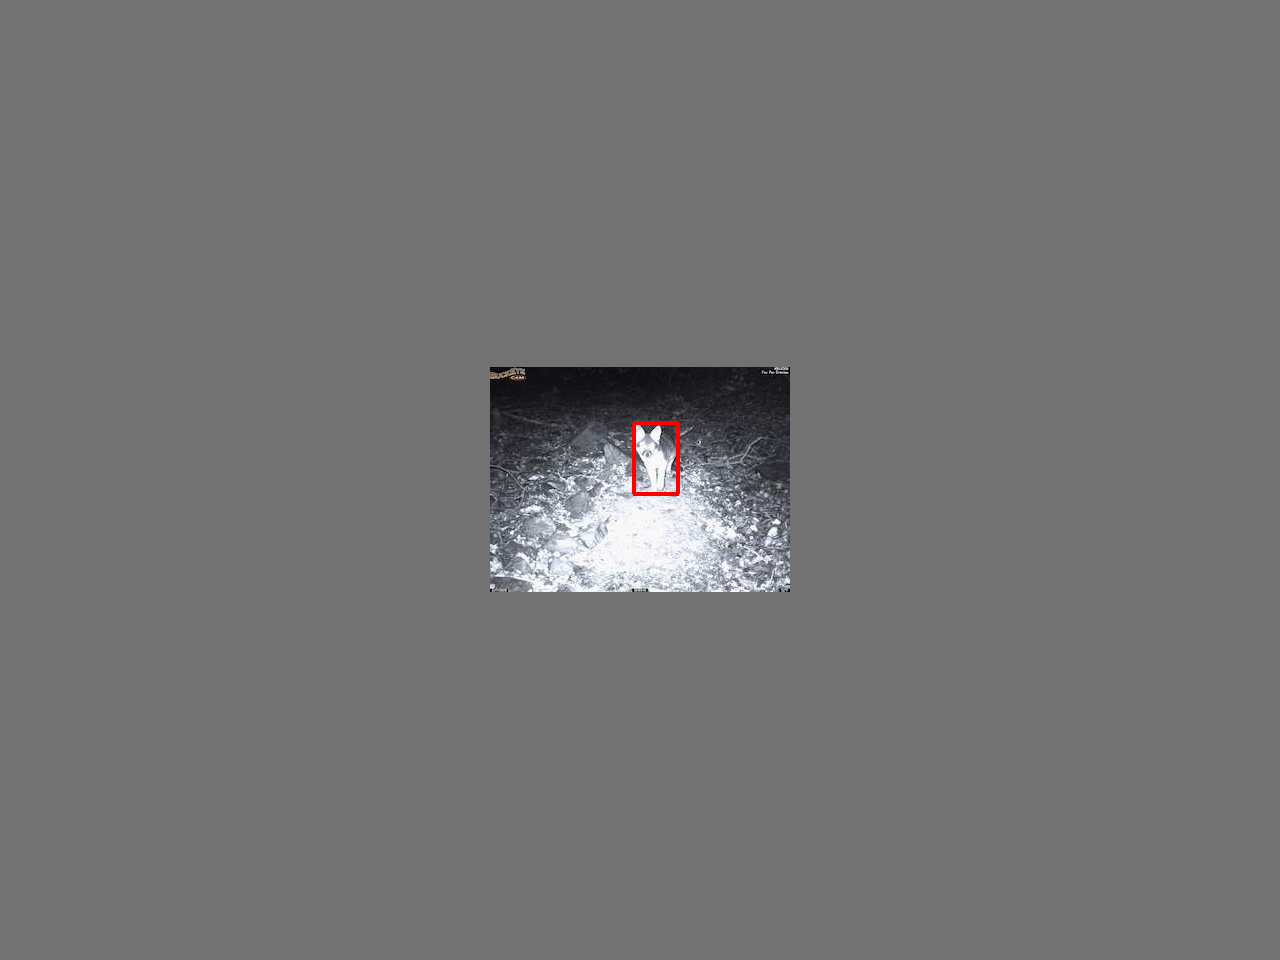

In [19]:
draw_bounding_box_on_image(resized_img_pil,norm_ys[0],norm_xs[0], norm_ys[1], norm_xs[1], 1)
resized_img_pil

### Plotting the detection (scaled) on the original image

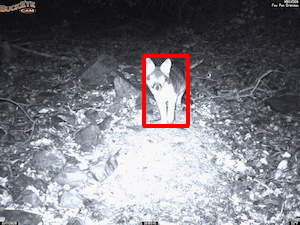

In [20]:
coords_big_img = scale_boxes(letterbox_shape, pred[0][0][:4], original_image_shape, (ratio,dw_dh))

norm_corrds_big_image = coords_big_img / torch.Tensor(original_image_shape)[[1, 0 , 1, 0]]


draw_bounding_box_on_image(original_image,norm_corrds_big_image[1],norm_corrds_big_image[0], norm_corrds_big_image[3], norm_corrds_big_image[2], 1)
original_image

## Testing TS container to plot

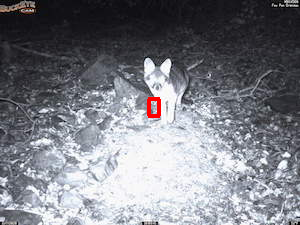

In [21]:
url = "http://127.0.0.1:8080/predictions/mdv5a"
headers = {
    "Content-Type": "application/octet-stream",
}

ts_top_results = {}
pth= "../../input/sample-img-fox.jpg"
with open(pth, "rb") as f:
    image_data = f.read()
# time.sleep(5)
response = httpx.post(url, data=image_data, headers=headers)

if response.status_code == 200:
    # do something with the response
    ts_top_results.update({pth.split("/")[-1]:response.json()[0]})

request_image= Image.open(pth)
pn = os.path.basename(pth)
draw_bounding_box_on_image(request_image, ts_top_results[pn]['y1'],ts_top_results[pn]['x1'],ts_top_results[pn]['y2'],ts_top_results[pn]['x2'],ts_top_results[pn]['class'])

request_image